# Stats Workflow

**Cara Piske, Graduate Program of Hydrologic Sciences, 2022; Advisor: Dr. Adrian Harpold**<br>
This code processes lidar-derived rasters to evaluate the difference between snow properties (SWE) in under vs. open canopy classifications. <br>
Lidar data were provided by the Airborne Snow Observatory (ASO), the National Center for Airborne Laser Mapping (NCALM), and Watershed Sciences Inc. (WSI). <br>

See: Varhola, A., Coops, N. C., Weiler, M., & Moore, R. D. (2010). Forest canopy effects on snow accumulation and ablation: An integrative review of empirical results. In Journal of Hydrology (Vol. 392, Issues 3–4, pp. 219–233). Elsevier. https://doi.org/10.1016/j.jhydrol.2010.22.009 <br>
and<br>
Kostadinov, T. S., Schumer, R., Hausner, M., Bormann, K. J., Gaffney, R., McGwire, K., Painter, T. H., Tyler, S., & Harpold, A. A. (2019). Watershed-scale mapping of fractional snow cover under conifer forest canopy using lidar. Remote Sensing of Environment, 222, 34–49. https://doi.org/10.1016/j.rse.2018.11.037

In [1]:

# import necessary packages 
from osgeo import gdal, ogr, osr
import csv
import os
import subprocess
import sys
import pdal
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import time
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import subprocess
import statsmodels.api as sm

# competing paths on our PC 
gdal_merge = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_merge.py')
gdal_calc = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_calc.py')
gdal_warp = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_warp.py')
gdal_polygonize = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_polygonize.py')
gdal_proximity = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_proximity.py')

In [2]:
#make sure we're in the right working directory
os.chdir('/')
print(os.getcwd())

G:\


## Load Data

In [3]:
# input - path = str. i.e. 'SCB/kane_veg_metrics/departure/14_withholes/departure_wh_clip2dem.tif'
# input - nd_value = int. no data value
# output - raster_arr = 1D array of raster values (maintaining columns)
def raster_to_array(path, nd_value):
    raster = gdal.Open(path) # open the file 
    raster_arr = raster.GetRasterBand(1).ReadAsArray() #read the first raster band (in this case we know we are only working with single bands) and read to a 2D array
    if raster_arr.dtype == 'int32':
        raster_arr = raster_arr.astype(float)
    raster_arr[raster_arr == nd_value] = np.nan # where the raster is equal to the provided no data value, set values to Nan
    raster_arr_flat = raster_arr.flatten() # flatten the array (row-wise)
    raster = None
    return raster_arr_flat

# Vegetation and Terrain

### Load Data- Create DataFrame

In [546]:
# terrain variables
DEM_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_BE_30m.tif', -9999)
nness_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_nness_30m.tif', -9999)
# vegetation variables
fVEG_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/fVeg/NCALM_SCB_20201120_fVEG_30m.tif', -9999)
canopy_density_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/fVeg/NCALM_SCB_20201120_canopy_density_30m.tif', -9999)
openness_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/NCALM_SCB_20201120_DNC_avgTAOheight_30m.tif', -9999)
openness_arr = np.log(openness_arr)
LAI_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/NCALM_SCB_20201120_LAI_prime_30m.tif', -9999)
delta_fVeg = raster_to_array('SCB/stats/canopy_differences/fVEG_2014_2020.tif', -9999)
CHM_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/CHM/NCALM_SCB_2020_CHM.tif', -9999)


(array([2.8840994e+07, 9.0746160e+06, 8.8193090e+06, 4.8338540e+06,
        1.3145690e+06, 1.8211200e+05, 1.6303000e+04, 5.4100000e+02,
        2.0000000e+00, 4.0000000e+00]),
 array([-0.149,  6.848, 13.845, 20.842, 27.839, 34.836, 41.833, 48.83 ,
        55.827, 62.824, 69.821]),
 <BarContainer object of 10 artists>)

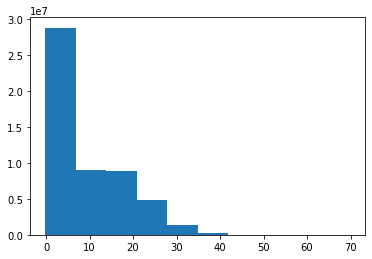

In [383]:
plt.hist(CHM_arr)

#### Define bins

In [378]:

terain_veg_dict = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "fVeg": fVEG_arr,
    "openness": openness_arr,
    "canopy_den":canopy_density_arr,
    'LAI':LAI_arr,
    'delta_fVeg': delta_fVeg
})
elev_bins_set = ([1800,2000,2100,2200,2300,2400,2800])# ([1850, 1900, 1950, 2000, 2050, 2100,2150, 2200,2250, 2300])#([1800,2000,2100,2200,2300,2400,2800])
nness_bins_set = ([-0.6,-0.3,0,0.3,0.6])
fVEG_bins_set = ([0,0.2,0.4,0.6,0.8,1.0]) # ([0,0.25,0.5, 0.75, 1.0])
opennes_bins = ([0,0.5,1,1.5, 2, 2.5, 3])
canopy_den_bins = ([0,0.2,0.4,0.6,0.8])
LAI_bins = ([0, 0.1, 0.2, 0.3, 0.4, 0.5])
delta_fVeg_bins = ([0,0.1,0.2,0.3, 0.4, 0.5, 0.6]) # filtered to remove negative values ([-0.4,-0.2,0,0.2,0.4,0.6])# 

In [379]:
terain_veg_dict['nness_bins'] = pd.cut(terain_veg_dict['nness'], bins=nness_bins_set, right = False,include_lowest= True)
terain_veg_dict['elev_bins'] = pd.cut(terain_veg_dict['elev'], bins=elev_bins_set, right = False,include_lowest= True)
terain_veg_dict['fVeg_bins'] = pd.cut(terain_veg_dict['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)
terain_veg_dict['openness_bins'] = pd.cut(terain_veg_dict['openness'], bins=opennes_bins, right = False,include_lowest= True)
terain_veg_dict['canopy_den_bins'] = pd.cut(terain_veg_dict['canopy_den'], bins=canopy_den_bins, right = False,include_lowest= True)
terain_veg_dict['LAI_bins'] = pd.cut(terain_veg_dict['LAI'], bins=LAI_bins, right = False,include_lowest= True)
terain_veg_dict['delta_fVeg_bins'] = pd.cut(terain_veg_dict['delta_fVeg'], bins=delta_fVeg_bins, right = False,include_lowest= True)

In [380]:
disturbed_filter = terain_veg_dict['delta_fVeg'] >= 0.1
undisturbed_filter =  terain_veg_dict['delta_fVeg'] < 0.1
terain_veg_dict['disturbance'] = np.nan
terain_veg_dict.loc[disturbed_filter,'disturbance'] = 'disturbed'
terain_veg_dict.loc[undisturbed_filter,'disturbance'] = 'undisturbed'


#### Plot

In [ ]:
# fVEG_box, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis
# # we want a scatterplot
# # specify figure axis (ax=axes)
# # data = dataframe name, x = dataframe column name, y = dataframe column name
# # hue = color values by variable, marker = specify style, s = size of marker, palette = color palette

# sns.boxplot(ax=axes, data=snow_veg_terrain_df, x='elev_bins', y="NCALM_2014_northness", hue = 'coreGap_bins',showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
# axes.set_title('Elevation vs. Northness', fontsize = 20)
# axes.set_xlabel('Elevation (m)', fontsize = 16)
# axes.set_ylabel('Northness', fontsize = 16)
# axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
# plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

# fVEG_box.savefig('SCB/stats/figures/nness_elev_GapSize.png',transparent=True,bbox_inches='tight',dpi=300)

**Elevation, Nness, Slope**

[Text(0, 0, '[1800, 2000)'),
 Text(1, 0, '[2000, 2100)'),
 Text(2, 0, '[2100, 2200)'),
 Text(3, 0, '[2200, 2300)'),
 Text(4, 0, '[2300, 2400)'),
 Text(5, 0, '[2400, 2800)')]

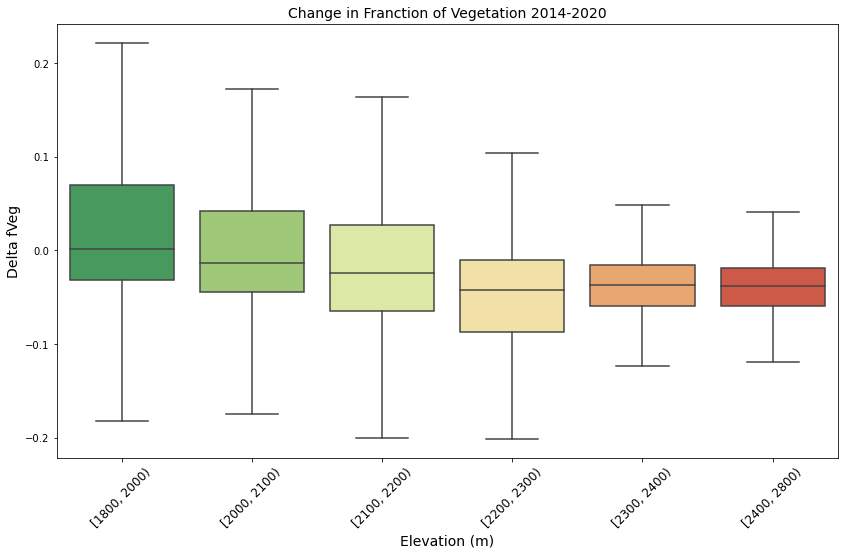

In [192]:
# delta fVeg filtered
# delta fVeg
elev_nness_fveg_fig, axes = plt.subplots(1,1,figsize=(14, 8), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=terain_veg_dict, x='elev_bins', y="delta_fVeg", showfliers = False,palette = 'RdYlGn_r') #, hue = 'nness_bins'
axes.set_title('Change in Franction of Vegetation 2014-2020', fontsize = 14); axes.set_xlabel('Elevation (m)', fontsize = 14); axes.set_ylabel('Delta fVeg', fontsize = 14)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12)
#axes.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0, title= 'Delta fVeg', fontsize=12)
#elev_nness_fveg_fig.savefig('SCB/stats/figures/terrain_veg/elev_nness_deltaFveg_filtered.png',transparent=True,bbox_inches='tight',dpi=300)

In [373]:
terain_veg_dict_fil = terain_veg_dict.copy()
terain_veg_dict_fil.delta_fVeg[terain_veg_dict_fil.delta_fVeg<0.1]=np.nan

C:\Users\cpiske\AppData\Local\Temp/ipykernel_41732/599935214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terain_veg_dict_fil.delta_fVeg[terain_veg_dict_fil.delta_fVeg<0.1]=np.nan


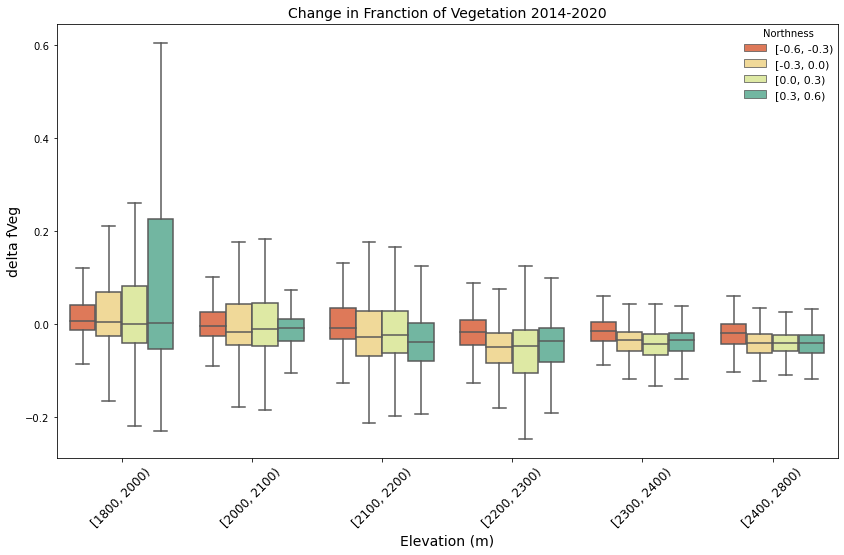

In [515]:
# delta fVeg filtered
# delta fVeg
elev_nness_fveg_fig, axes = plt.subplots(1,1,figsize=(14, 8), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=terain_veg_dict, x='elev_bins', y="delta_fVeg", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes.set_title('Change in Franction of Vegetation 2014-2020', fontsize = 14); axes.set_xlabel('Elevation (m)', fontsize = 14); axes.set_ylabel('delta fVeg', fontsize = 14)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12)
axes.legend( loc='upper right', borderaxespad=0, title= 'Northness', fontsize=11, frameon=False)
elev_nness_fveg_fig.savefig('SCB/stats/figures/terrain_veg/elev_nness_deltaFveg.png',transparent=True,bbox_inches='tight',dpi=300)

terrain vs veg

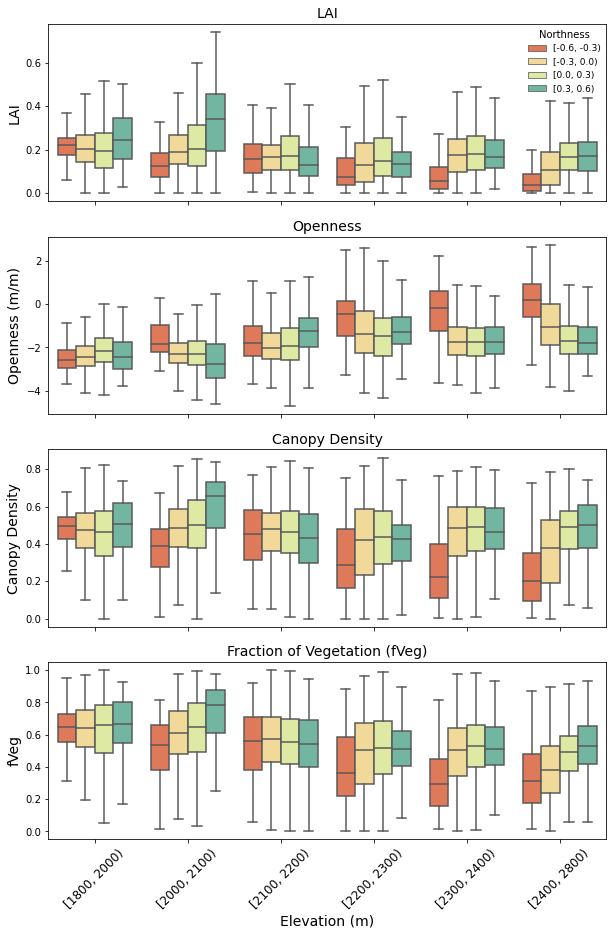

In [517]:
elev_nness_fveg_fig, axes = plt.subplots(4,1,figsize=(10, 15), sharey=False) # create a figure axis
sns.boxplot(ax=axes[0], data=terain_veg_dict, x='elev_bins', y="LAI", hue = 'nness_bins', showfliers = False, palette = 'Spectral') #, hue = 'nness_bins'
axes[0].set_title('LAI', fontsize = 14); axes[0].set_xlabel(''); axes[0].set_ylabel('LAI', fontsize = 14)
axes[0].set_xticklabels([])
axes[0].legend(loc='upper right', borderaxespad=0.2, title= 'Northness', fontsize=9, frameon=False)
#axes[0].text(-0.40, 0.7,"a", ha="left", va="top", size='medium', color='black', weight='normal')

sns.boxplot(ax=axes[1], data=terain_veg_dict, x='elev_bins', y="openness", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[1].set_title('Openness', fontsize = 14); axes[1].set_xlabel(''); axes[1].set_ylabel('Openness (m/m)', fontsize = 14)
axes[1].set_xticklabels([])
#axes[1].set_yscale("log")
axes[1].legend([],frameon=False)#(bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'Northness', fontsize=12)
#axes[1].text(-0.40, 0.7,"b", ha="left", va="top", size='medium', color='black', weight='normal')

sns.boxplot(ax=axes[2], data=terain_veg_dict, x='elev_bins', y="canopy_den", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[2].set_title('Canopy Density', fontsize = 14); axes[2].set_xlabel(''); axes[2].set_ylabel('Canopy Density', fontsize = 14)
axes[2].set_xticklabels([])
axes[2].legend([],frameon=False)#bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0, title= 'Northness', fontsize=12)
#axes[2].text(-0.40, 0.7,"c", ha="left", va="top", size='medium', color='black', weight='normal')

sns.boxplot(ax=axes[3], data=terain_veg_dict, x='elev_bins', y="fVeg", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[3].set_title('Fraction of Vegetation (fVeg)', fontsize = 14); axes[3].set_xlabel('Elevation (m)', fontsize = 14); axes[3].set_ylabel('fVeg', fontsize = 14)
axes[3].set_xticklabels(axes[3].get_xticklabels(),rotation = 45, fontsize = 12)
axes[3].legend([],frameon=False)#bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0, title= 'Northness', fontsize=12)
#axes[3].text(-0.40, 0.7,"d", ha="left", va="top", size='medium', color='black', weight='normal')

elev_nness_fveg_fig.savefig('SCB/stats/figures/terrain_veg/elev_nness_veg_postDist.png',transparent=True,bbox_inches='tight',dpi=300)

# Delta Change in Snowpack Properties
We'll start off using only our best estimate of snowpack accumulation, which is the earliest flight available from each year. <br>

## Accumulation
Calculated as the difference between open and tall snowpack

### Load Data - Create Dataframe

In [385]:
# Start with the ASO flight
NCALM_2022_open = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/SWE/NCALM_SCB_20220321_SWE_open_buffered_30m.tif'
NCALM_2022_tall = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/SWE/NCALM_SCB_20220321_SWE_tall_30m.tif'
NCALM_2022_all = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/SWE/NCALM_SCB_20220321_SWE_30m.tif'

NCALM_delta_acc = 'SCB/stats/delta_accumulation_rasters/NCALM_20220321_deltaAccumulation.tif'
NCALM_delta_acc_raw = 'SCB/stats/delta_accumulation_rasters/NCALM_20220321_deltaAccumulation_raw.tif'
NCALM_delta_acc_abs = 'SCB/stats/delta_accumulation_rasters/NCALM_20220321_deltaAccumulation_abs.tif'

NCALM_delta_acc_tall = 'SCB/stats/delta_accumulation_rasters/NCALM_20220321_deltaAccumulation_tallRef.tif'

In [384]:
ASO_2016_all = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_30m.tif'
ASO_delta_2016 = 'SCB/stats/delta_accumulation_rasters/ASO_20160326_deltaAccumulation.tif'

NCALM_2008_all = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/SWE/NCALM_SCB_20080210_SWE_30m.tif'
NCALM_delta_2008 = 'SCB/stats/delta_accumulation_rasters/NCALM_20080210_deltaAccumulation.tif'

In [44]:
# # snowpalm data
# snowpalm = np.loadtxt('SCB/supporting_files/snowPALM/Sagehen_varhola_data.csv', skiprows=1,delimiter=",")

In [45]:
# snowpalm_df = pd.DataFrame()
# snowpalm_df['fVeg'] = snowpalm[:,0]
# snowpalm_df['delta_acc_2016'] = snowpalm[:,1]

Calculate delta change in accumulation

In [46]:
# delta_accumulation_cmd = ['python',gdal_calc, '-A', NCALM_2022_open,'-B',NCALM_2022_all,'--NoDataValue','-9999',
#  '--outfile', NCALM_delta_acc_raw, '--calc="(B-A)/A*100"','--overwrite']
# subprocess.run(delta_accumulation_cmd)

# delta_accumulation_cmd = ['python',gdal_calc, '-A', NCALM_2022_open,'-B',NCALM_2022_all,'--NoDataValue','-9999',
#  '--outfile', NCALM_delta_acc_abs, '--calc="(B-A)"','--overwrite']
# subprocess.run(delta_accumulation_cmd)

In [7]:
# delta_accumulation_cmd = ['python',gdal_calc, '-A', NCALM_delta_acc_raw,'--NoDataValue','-9999',
#  '--outfile', NCALM_delta_acc, '--calc="A*(A<200)"','--overwrite']
# subprocess.run(delta_accumulation_cmd)

CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/stats/delta_accumulation_rasters/NCALM_20220321_deltaAccumulation_raw.tif', '--NoDataValue', '-9999', '--outfile', 'SCB/stats/delta_accumulation_rasters/NCALM_20220321_deltaAccumulation.tif', '--calc="A*(A<200)"', '--overwrite'], returncode=0)

In [116]:
# load into array
NCALM_delta_acc_arr = raster_to_array(NCALM_delta_acc, -9999)
NCALM_2022_all_arr = raster_to_array(NCALM_2022_all, -9999)
#NCALM_delta_acc_arr_tall = raster_to_array(NCALM_delta_acc_tall, -9999)
NCALM_2022_open_arr = raster_to_array(NCALM_2022_open, -9999)
NCALM_2022_tall_arr = raster_to_array(NCALM_2022_tall, -9999)

ASO_2016_all_arr = raster_to_array(ASO_2016_all, -9999)

In [207]:
acc_df = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "fVeg": fVEG_arr,
    "delta_fVeg": delta_fVeg,
    'SWE_2022': NCALM_2022_all_arr,
    'delta_acc_NCALM': NCALM_delta_acc_arr,
    'SWE_2016':ASO_2016_all_arr
})

ASO_acc_bins = ([0, 25,50,75, 100, 150, 200])
NCALM_acc_bins = ([0, 25, 50, 75, 100, 125, 150])
NCALM_delta_acc_bins = ([-40, -30, -20, -10, 0, 10, 20, 30])

acc_df['nness_bins'] = pd.cut(acc_df['nness'], bins=nness_bins_set, right = False,include_lowest= True)
acc_df['elev_bins'] = pd.cut(acc_df['elev'], bins=elev_bins_set, right = False,include_lowest= True)
acc_df['fVeg_bins'] = pd.cut(acc_df['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)
acc_df['delta_fVeg_bins'] = pd.cut(acc_df['delta_fVeg'], bins=delta_fVeg_bins, right = False,include_lowest= True)
acc_df['SWE_2022_bins'] = pd.cut(acc_df['SWE_2022'], bins=ASO_acc_bins, right = False,include_lowest= True)
acc_df['deltaSWE_2022_bins'] = pd.cut(acc_df['delta_acc_NCALM'], bins=NCALM_delta_acc_bins, right = False,include_lowest= True)


#elev_bins_arr = acc_df['elev_bins'].unique()
#elev_bins_arr_sort = [elev_bins_arr.categories[0],elev_bins_arr.categories[1], elev_bins_arr.categories[2],elev_bins_arr.categories[3],elev_bins_arr.categories[4],elev_bins_arr.categories[5]] # create a new list with sorted values

In [245]:
disturbed_filter = acc_df['delta_fVeg'] >= 0.1
undisturbed_filter =  acc_df['delta_fVeg'] < 0.1
acc_df['disturbed'] = np.nan
acc_df.loc[disturbed_filter,'disturbed'] = 'Disturbed'
acc_df.loc[undisturbed_filter,'disturbed'] = 'Undisturbed'


### Run differencing pre-post

In [209]:
acc_df['SWE_diff'] = (acc_df.SWE_2022 / np.mean(acc_df.SWE_2022)) - (acc_df.SWE_2016 / np.mean(acc_df.SWE_2016))

In [210]:
acc_df['nSWE_2022'] = acc_df.SWE_2022 / np.mean(acc_df.SWE_2022)
acc_df['nSWE_2016'] = acc_df.SWE_2016 / np.mean(acc_df.SWE_2016)

In [211]:
SWE_diff_bins_set = ([-1, -0.5, 0, 0.5, 1,])
acc_df['SWE_diff_bins'] = pd.cut(acc_df['SWE_diff'], bins=SWE_diff_bins_set, right = False,include_lowest= True)


### Percentage area df(s)

In [334]:
# SWE_fil_na = acc_df['SWE_2022'].isna()
# SWE_fil = SWE_fil_na == False
# per_elev_df.loc[SWE_fil_na,'pixel'] = 0
# per_elev_df.loc[SWE_fil,'pixel'] = 1

per_elev_df = acc_df.copy()
per_elev_df['pixel'] = 1

disturbed_filter = acc_df['delta_fVeg'] >= 0.1
undisturbed_filter =  acc_df['delta_fVeg'] < 0.1
per_elev_df['disturbed'] = np.nan
per_elev_df.loc[disturbed_filter,'disturbed'] = 1
per_elev_df.loc[undisturbed_filter,'disturbed'] = 0

elev_bins_set_d = ([1850, 1900, 1950, 2000, 2050, 2100,2150, 2200,2250, 2300, 2350, 2400])#([1800,2000,2100,2200,2300,2400,2800])
per_elev_df['elev_bins'] = pd.cut(per_elev_df['elev'], bins=elev_bins_set_d, right = False,include_lowest= True)


In [335]:
elev_df = per_elev_df.groupby('elev_bins')['elev'].mean().reset_index()

In [336]:
per_dist_df = per_elev_df.groupby('elev_bins')['disturbed'].sum().reset_index()
per_all_df = per_elev_df.groupby('elev_bins')['pixel'].sum().reset_index()

per_dist_df['elev'] = elev_df['elev']
per_all_df['elev'] = elev_df['elev']

per_dist_df['class'] = 'Disturbed'
per_all_df['class'] = 'All'

In [337]:
per_dist_df.rename(columns = {'disturbed':'pixel'}, inplace = True)

In [341]:
per_elev_df = pd.concat([per_dist_df,per_all_df]).reset_index(drop=True)
per_elev_df.pixel = per_elev_df.pixel/ np.sum(per_all_df.pixel)*100

# Plot

## disturbance investigation

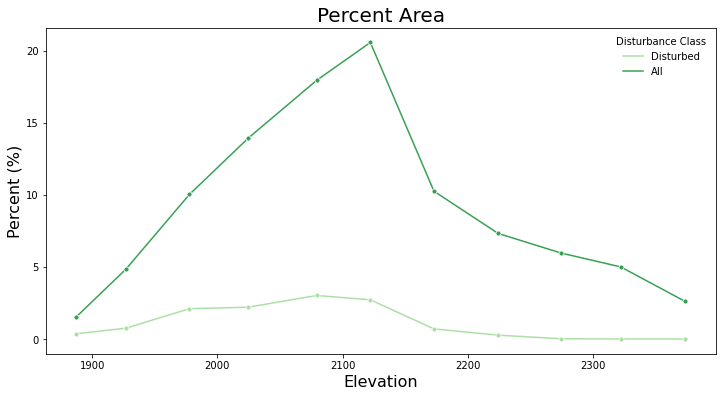

In [518]:
elev_scatter, axes = plt.subplots(1,1,figsize=(12, 6)) # create a figure axis
sns.lineplot(ax=axes, data=per_elev_df, x='elev', y="pixel", hue = 'class', marker ='o', markersize=5, palette = 'Greens') #, hue = 'nness_bins'
axes.set_title('Percent Area', fontsize = 20)
axes.set_ylabel('Percent (%)', fontsize = 16)
axes.set_xlabel('Elevation', fontsize = 16)
axes.legend(frameon=False,title = "Disturbance Class")
elev_scatter.savefig('SCB/stats/figures/random_forest/post_disturbance/percent_elevation.png',transparent=True,bbox_inches='tight',dpi=300)

Text(0.5, 0, 'SWE 2016')

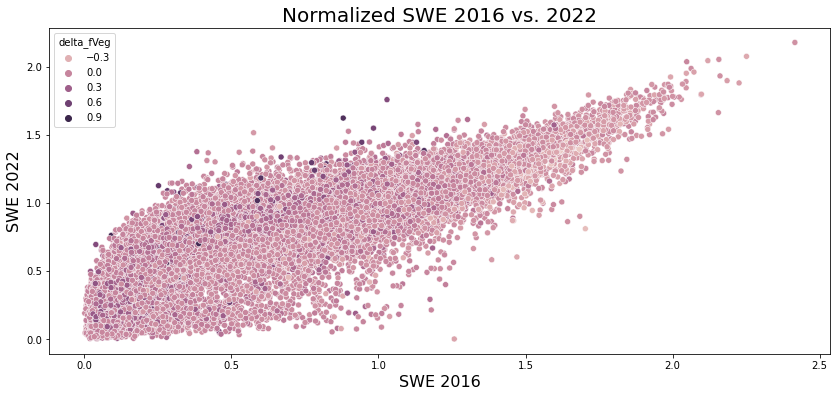

In [134]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis

sns.scatterplot(x=acc_df["nSWE_2016"][acc_df.elev <2200], y=acc_df["nSWE_2022"][acc_df.elev < 2200], hue = acc_df["delta_fVeg"][acc_df.elev < 2200])#,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Normalized SWE 2016 vs. 2022', fontsize = 20)
axes.set_ylabel('SWE 2022', fontsize = 16)
axes.set_xlabel('SWE 2016', fontsize = 16)


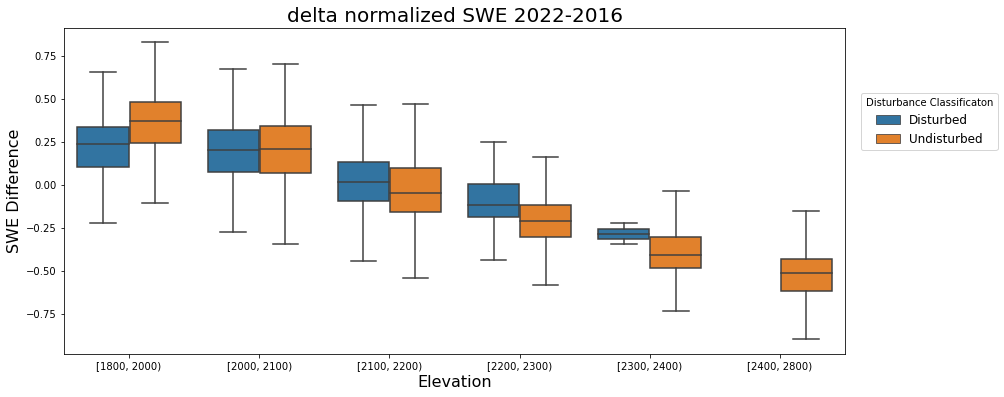

In [519]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="SWE_diff",showfliers = False, hue = 'disturbed')#,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('delta normalized SWE 2022-2016', fontsize = 20)
axes.set_ylabel('SWE Difference', fontsize = 16)
axes.set_xlabel('Elevation', fontsize = 16)
axes.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0, title= 'Disturbance Classificaton', fontsize=12)
#fig.savefig('SCB/stats/figures/snow_terrain_veg//elev_nd_absSWE.png',transparent=True,bbox_inches='tight',dpi=300)

In [168]:
acc_df.columns

Index(['elev', 'nness', 'fVeg', 'delta_fVeg', 'SWE_2022', 'delta_acc_NCALM',
       'SWE_2016', 'nness_bins', 'elev_bins', 'fVeg_bins', 'delta_fVeg_bins',
       'SWE_2022_bins'],
      dtype='object')

## Snow-terrain-veg

In [239]:
acc_df.columns

Index(['elev', 'nness', 'fVeg', 'delta_fVeg', 'SWE_2022', 'delta_acc_NCALM',
       'SWE_2016', 'nness_bins', 'elev_bins', 'fVeg_bins', 'delta_fVeg_bins',
       'SWE_2022_bins', 'deltaSWE_2022_bins', 'disturbed', 'SWE_diff',
       'nSWE_2022', 'nSWE_2016', 'SWE_diff_bins'],
      dtype='object')

In [ ]:
# create new elevation bins to split x axis for ear/late season ablation 

#abl_df_filtered_early = abl_df[abl_df.elev<2200]
#abl_df.elev_bins
elev_bins_set_b = ([1800,2000,2050,2100, 2150, 2200])
acc_df['elev_bins_b'] = pd.cut(acc_df['elev'], bins=elev_bins_set_b, right = False,include_lowest= True)
elev_bins_set_c = ([2200,2250,2300,2350,2400, 2450, 2500])
acc_df['elev_bins_c'] = pd.cut(acc_df['elev'], bins=elev_bins_set_c, right = False,include_lowest= True)

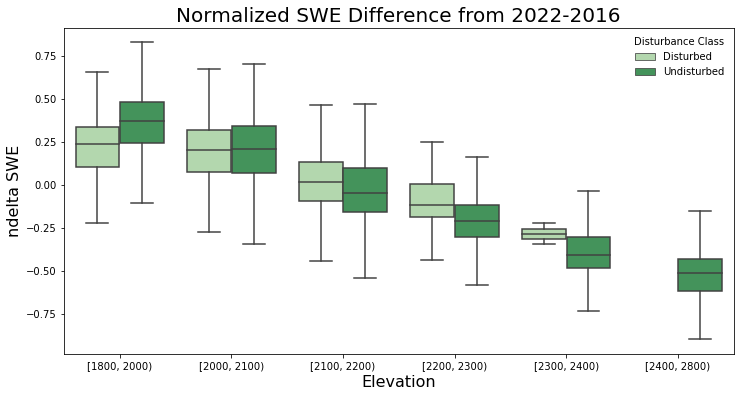

In [520]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(12, 6), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="SWE_diff",showfliers = False, hue = 'disturbed',palette = 'Greens') #, hue = 'nness_bins'
axes.set_title('Normalized SWE Difference from 2022-2016', fontsize = 20)
axes.set_ylabel('ndelta SWE', fontsize = 16)
axes.set_xlabel('Elevation', fontsize = 16)
axes.legend(frameon=False,title = "Disturbance Class")
elev_SWE_box.savefig('SCB/stats/figures/random_forest/post_disturbance/delta_SWE_elev_dist.png',transparent=True,bbox_inches='tight',dpi=300)

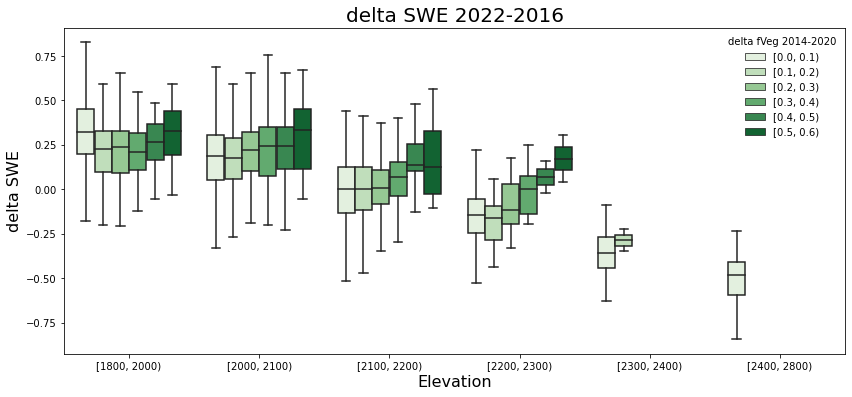

In [521]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="SWE_diff",showfliers = False, hue = 'delta_fVeg_bins',palette = 'Greens') #, hue = 'nness_bins'
axes.set_title('delta SWE 2022-2016', fontsize = 20)
axes.set_ylabel('delta SWE', fontsize = 16)
axes.set_xlabel('Elevation', fontsize = 16)
axes.legend(frameon=False,title = "delta fVeg 2014-2020")
elev_SWE_box.savefig('SCB/stats/figures/random_forest/post_disturbance/delta_SWE_elev_deltafVeg.png',transparent=True,bbox_inches='tight',dpi=300)

In [156]:
acc_df.columns

Index(['elev', 'nness', 'fVeg', 'delta_fVeg', 'SWE_2022', 'delta_acc_NCALM',
       'SWE_2016', 'nness_bins', 'elev_bins', 'fVeg_bins', 'delta_fVeg_bins',
       'SWE_diff', 'nSWE_2022', 'nSWE_2016', 'disturbed', 'SWE_diff_bins'],
      dtype='object')

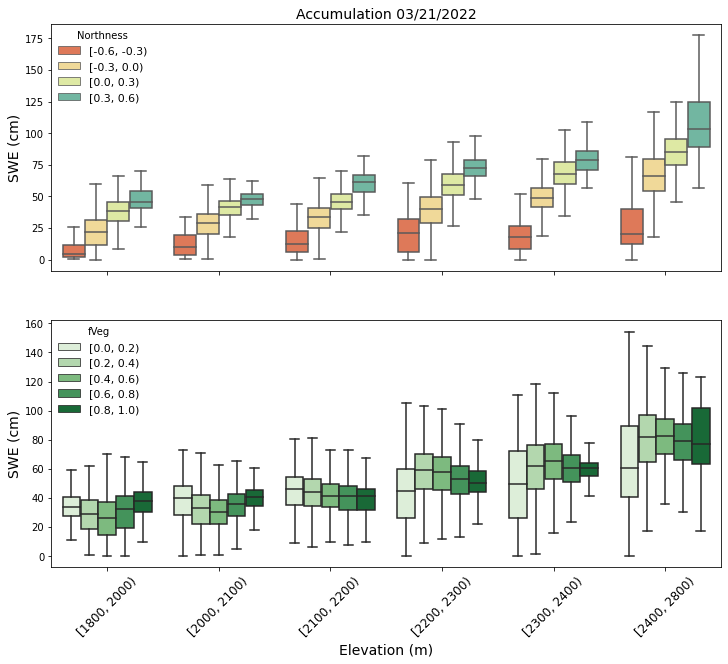

In [522]:
elev_nness_fveg_fig, axes = plt.subplots(2,1,figsize=(12, 10), sharey=False) # create a figure axis
sns.boxplot(ax=axes[0], data=acc_df, x='elev_bins', y="SWE_2022", hue = 'nness_bins', showfliers = False, palette = 'Spectral') #, hue = 'nness_bins'
axes[0].set_title('Accumulation 03/21/2022', fontsize = 14); axes[0].set_xlabel(''); axes[0].set_ylabel('SWE (cm)', fontsize = 14)
axes[0].set_xticklabels([])
axes[0].legend(loc='upper left', borderaxespad=0.2, title= 'Northness', fontsize=11,frameon=False)
#axes[0].text(-0.40, .81,"a", ha="left", va="top", size=12, color='black', weight='normal')

sns.boxplot(ax=axes[1], data=acc_df, x='elev_bins', y="SWE_2022", hue = 'fVeg_bins', showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes[1].set_title('', fontsize = 14); axes[1].set_xlabel('Elevation (m)', fontsize = 14); axes[1].set_ylabel('SWE (cm)', fontsize = 14)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 45, fontsize = 12)
axes[1].legend( loc='upper left', borderaxespad=0.2, title= 'fVeg', fontsize=11,frameon=False)
#axes[1].text(-0.40, 1.12,"b", ha="left", va="top", size=12, color='black', weight='normal')
elev_nness_fveg_fig.savefig('SCB/stats/figures/snow_terrain_veg/SWE_terrain_postDist.png',transparent=True,bbox_inches='tight',dpi=300)

In [212]:
acc_df.columns

Index(['elev', 'nness', 'fVeg', 'delta_fVeg', 'SWE_2022', 'delta_acc_NCALM',
       'SWE_2016', 'nness_bins', 'elev_bins', 'fVeg_bins', 'delta_fVeg_bins',
       'SWE_2022_bins', 'deltaSWE_2022_bins', 'disturbed', 'SWE_diff',
       'nSWE_2022', 'nSWE_2016', 'SWE_diff_bins'],
      dtype='object')

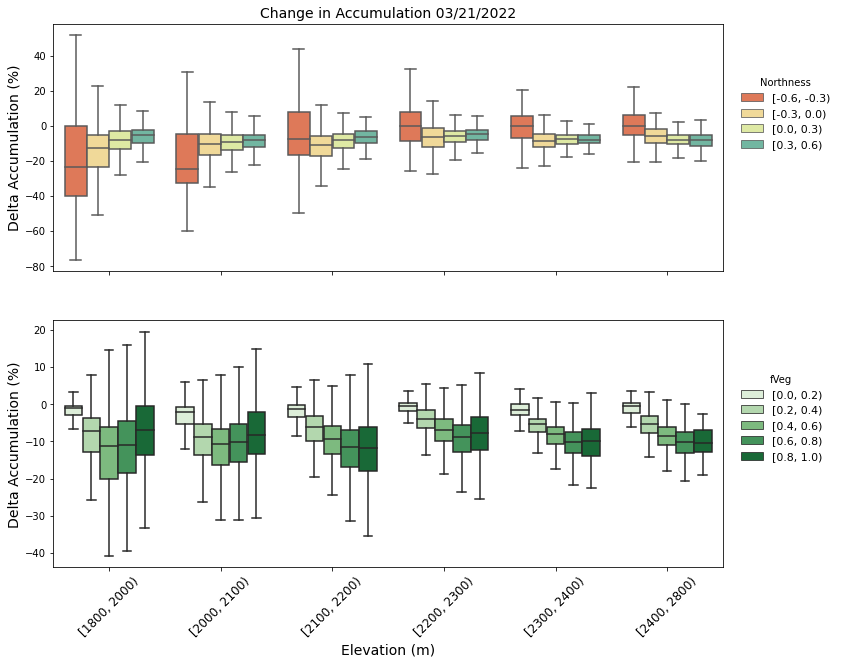

In [523]:
elev_nness_fveg_fig, axes = plt.subplots(2,1,figsize=(12, 10), sharey=False) # create a figure axis
sns.boxplot(ax=axes[0], data=acc_df, x='elev_bins', y="delta_acc_NCALM", hue = 'nness_bins', showfliers = False, palette = 'Spectral') #, hue = 'nness_bins'
axes[0].set_title('Change in Accumulation 03/21/2022', fontsize = 14); axes[0].set_xlabel(''); axes[0].set_ylabel('Delta Accumulation (%)', fontsize = 14)
axes[0].set_xticklabels([])
axes[0].legend(bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'Northness', fontsize=11,frameon=False)
#axes[0].text(-0.40, .69,"a", ha="left", va="top", size=12, color='black', weight='normal')

sns.boxplot(ax=axes[1], data=acc_df, x='elev_bins', y="delta_acc_NCALM", hue = 'fVeg_bins', showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes[1].set_title('', fontsize = 14); axes[1].set_xlabel('Elevation (m)', fontsize = 14); axes[1].set_ylabel('Delta Accumulation (%)', fontsize = 14)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 45, fontsize = 12)
axes[1].legend(bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'fVeg', fontsize=11,frameon=False)
#axes[1].text(-0.40, 1.11,"b", ha="left", va="top", size=12, color='black', weight='normal')

elev_nness_fveg_fig.savefig('SCB/stats/figures/snow_terrain_veg/delta_SWE_terrain_postDist.png',transparent=True,bbox_inches='tight',dpi=300)

In [525]:
# fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

# sns.scatterplot(ax=axes, data=acc_df, x='fVeg', y="delta_acc_NCALM", hue='swe_220321',palette='Blues') #, hue = 'nness_bins'
# axes.set_title('fVeg vs. Change in Accumulation 03/21/2022', fontsize = 20)
# axes.set_xlabel('Fraction of Canopy', fontsize = 16)
# axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
# axes.set(ylim=(-100, 100))

# #axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
# plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

# #fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_ASO_delta_SWE_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

In [ ]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=acc_df, x='fVeg', y="delta_acc_NCALM", hue='swe_220321',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 02/10/2022', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
axes.set(ylim=(-60, 40))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_NCALM_delta_SWE_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

In [ ]:
abl_df.columns

In [203]:
acc_df.columns

Index(['elev', 'nness', 'fVeg', 'delta_fVeg', 'SWE_2022', 'delta_acc_NCALM',
       'SWE_2016', 'nness_bins', 'elev_bins', 'fVeg_bins', 'delta_fVeg_bins',
       'SWE_2022_bins', 'disturbed', 'SWE_diff', 'nSWE_2022', 'nSWE_2016',
       'SWE_diff_bins'],
      dtype='object')

Text(0.5, 0, 'Elevation')

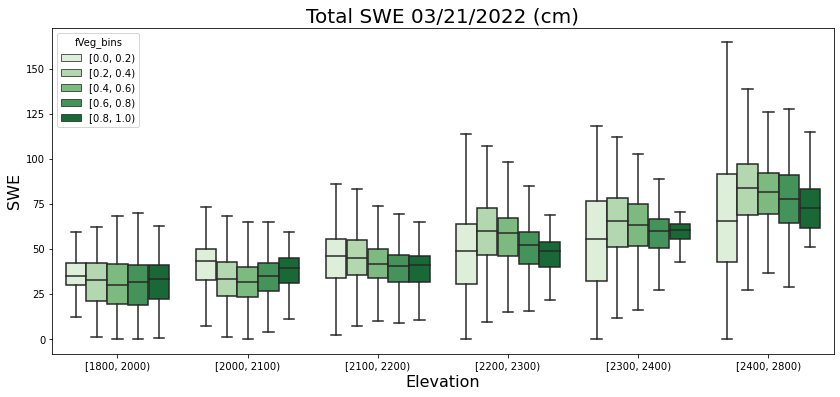

In [69]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_220321",showfliers = False, hue = 'fVeg_bins', palette="Greens")#,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Total SWE 03/21/2022 (cm)', fontsize = 20)
axes.set_ylabel('SWE', fontsize = 16)
axes.set_xlabel('Elevation', fontsize = 16)


Text(0.5, 0, 'Elevation')

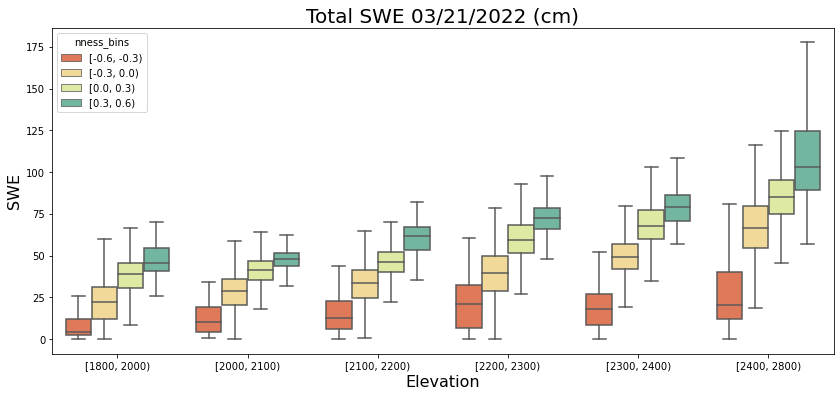

In [65]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_220321",showfliers = False, hue = 'nness_bins', palette="Spectral")#,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Total SWE 03/21/2022 (cm)', fontsize = 20)
axes.set_ylabel('SWE', fontsize = 16)
axes.set_xlabel('Elevation', fontsize = 16)

Text(0, 0.5, 'SWE (cm)')

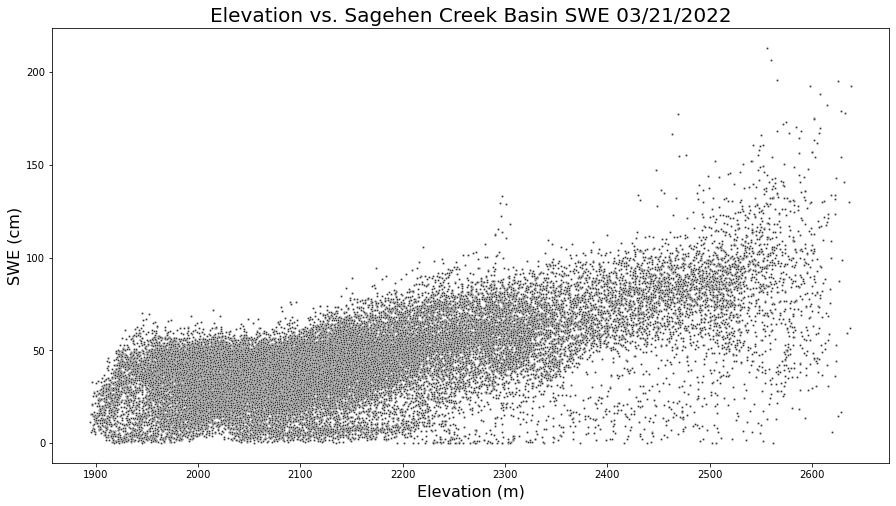

In [64]:
elev_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(data=acc_df, x="elev", y="swe_220321", s=20, color=".2", marker=".")
axes.set_title('Elevation vs. Sagehen Creek Basin SWE 03/21/2022', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 16)
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

#elev_SWE_scatter.savefig('SCB/stats/figures/elev_SWE_0321_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

In [62]:
# nness_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

# sns.scatterplot(data=acc_df, x="nness", y="swe_220321", s=20, color=".2", marker=".")
# axes.set_title('Northness vs. Sagehen Creek Basin SWE 03/21/2022', fontsize = 20)
# axes.set_xlabel('Northness', fontsize = 16)
# axes.set_ylabel('SWE (cm)', fontsize = 16)
# #axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 16)
# #plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

# #nness_SWE_scatter.savefig('SCB/stats/figures/nness_SWE_0321_scatter.png',transparent=True,bbox_inches='tight',dpi=300)


In [57]:
elev_bins_arr = acc_df['elev_bins'].unique()
elev_bins_arr_sort = [elev_bins_arr.categories[0],elev_bins_arr.categories[1], elev_bins_arr.categories[2],elev_bins_arr.categories[3],elev_bins_arr.categories[4],elev_bins_arr.categories[5]] # create a new list with sorted values

In [58]:
acc_df.columns

Index(['elev', 'nness', 'fVeg', 'swe_220321', 'delta_acc_NCALM', 'nness_bins',
       'elev_bins'],
      dtype='object')

# Regressions

In [ ]:
# with sklearn, run single variable regression
# a downside of this approach is that the input dataframe contains unnecessary data. For now, that's okay
# input: dataframe - pandas dataframe with ind and dep variables
# input: var1 & var2 - independent and dependent variable names (str)
# output: regr_model - sklearn LinearRegreassion()
# output: regression_df - dataframe with residual value
def sing_var_regress(dataframe, var1, var2):
    # establish ind. and dep. variables
    regression_df = dataframe[[var1,var2]].dropna(subset=[var1,var2])
    ind_df = regression_df[[var1]]
    dep_df = regression_df[[var2]]
    # run regression model 
    regr_model = linear_model.LinearRegression()
    regr_model.fit(ind_df,dep_df)
    # calculate residuals
    residual_var = dep_df.values - regr_model.predict(ind_df)
    predicted_var = regr_model.predict(ind_df)
    regression_df.insert(len(regression_df.columns), "residual_var", residual_var, True)
    regression_df.insert(len(regression_df.columns), "predicted_var", predicted_var, True)

    return regr_model, regression_df

In [ ]:
acc_df.columns

In [ ]:
abl_df.columns

In [ ]:
regr_model, regression_df = sing_var_regress(abl_df, 'elev', 'abl_AprMay')
print('r-squared: \n',r2_score(regression_df['abl_AprMay'],regr_model.predict(regression_df[['elev']])))

In [ ]:
#sns.scatterplot(data=regression_df, x="elev", y="residual_var")

In [ ]:
acc_df

In [ ]:
regression_df.columns

In [ ]:
# using statsmodel
regression_df = acc_df[["elev","nness","fVeg","DNC","clump", "swe_220321","delta_acc_NCALM"]].dropna(subset=["elev","nness","fVeg","DNC","clump", "swe_220321","delta_acc_NCALM"])
Y = regression_df['delta_acc_NCALM']
X = regression_df[["elev","nness","fVeg","DNC","clump"]]
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

# Varhola comp test w/ snowpalm

In [ ]:
snowpalm_df

In [ ]:
# load into array
ASO_0326_open_arr = raster_to_array(ASO_0326_open, -9999)
ASO_0326_tall_arr = raster_to_array(ASO_0326_tall, -9999)
ASO_0326_all_arr = raster_to_array(ASO_0326_all, -9999)
ASO_delta_acc_arr = raster_to_array(ASO_delta_acc, -9999)
ASO_delta_acc_tall_arr = raster_to_array(ASO_delta_acc_tall, -9999)


In [ ]:
test_df = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "slope": slope_arr,
    "fVeg": fVEG_arr,
    "ASO_0326_open":ASO_0326_open_arr,
    "ASO_0326_tall":ASO_0326_tall_arr,
    "ASO_0326_all":ASO_0326_all_arr,
    "ASO_delta_acc":ASO_delta_acc_arr,
    "ASO_delta_acc_tall":ASO_delta_acc_tall_arr
})
elev_bins_set = ([1800,2000,2100,2200,2300,2400,2800])
nness_bins_set = ([-0.6,-0.3,0,0.3,0.6])
fVEG_bins_set = ([0,0.25,0.5, 0.75, 1.0])
DNC_bins_set = ([0,5,10,15,20])
clump_bins_set = ([0, 0.5, 1, 1.5, 2])


test_df['nness_bins'] = pd.cut(test_df['nness'], bins=nness_bins_set, right = False,include_lowest= True)
test_df['elev_bins'] = pd.cut(test_df['elev'], bins=elev_bins_set, right = False,include_lowest= True)
test_df['fVeg_bins'] = pd.cut(test_df['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)
elev_bins_arr = acc_df['elev_bins'].unique()
nness_bins_arr = acc_df['nness_bins'].unique()

In [ ]:
test_df['tall_ref'] = np.nan
for i in range(6):
    for j in range(5):
        tall_all = test_df.ASO_0326_tall[(test_df['elev_bins']==elev_bins_arr[i]) & (test_df['nness_bins']==nness_bins_arr[j])]
        tall_avg = np.nanmean(tall_all)
        test_df.tall_ref[(test_df['elev_bins']==elev_bins_arr[i]) & (test_df['nness_bins']==nness_bins_arr[j])] = tall_avg

In [ ]:
test_df['delta_acc_tallRef'] = (test_df['ASO_0326_all'] -  test_df['tall_ref'])/test_df['tall_ref']*100
test_df['fVeg'] = -(1-test_df['fVeg'])*100

In [ ]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=test_df, x='fVeg', y="delta_acc_tallRef", hue='ASO_0326_all',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 03/26/2016', fontsize = 20)
axes.set_xlabel('Change in Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
#axes.set(ylim=(-60, 40))
sns.lineplot(ax=axes, data=snowpalm_df, x='fVeg', y="delta_acc_2016", color='k') #, hue = 'nness_bins'

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_ASO_delta_SWE_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

In [ ]:
test_df['fVeg_avg'] = round(test_df.fVeg,2)

In [ ]:
test_avg_df = test_df.groupby('fVeg_avg').mean()

In [ ]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=test_avg_df, x='fVeg', y="delta_acc_tallRef", hue='ASO_0326_all',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 03/26/2016', fontsize = 20)
axes.set_xlabel('Change in Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
#axes.set(ylim=(-60, 40))
sns.lineplot(ax=axes, data=snowpalm_df, x='fVeg', y="delta_acc_2016", color='k') #, hue = 'nness_bins'

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_ASO_delta_SWE_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

# Final Classification Figure

## Calculate response

In [9]:
fVEG_2020 = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/fVeg/NCALM_SCB_20201120_fVEG_30m.tif'
openness_2020 = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/NCALM_SCB_20201120_DNC_avgTAOheight_30m.tif'
log_openness_2020 = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/NCALM_SCB_20201120_logOpenness_30m.tif'

fVEG_2014 = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/canopy_metrics/veg_structure/fVeg/NCALM_SCB_2014_fVEG_30m.tif'
openness_2014 ='SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/canopy_metrics/veg_structure/NCALM_SCB_2014_DNC_avgTAOheight_30m.tif'
log_openness_2014 ='SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/canopy_metrics/veg_structure/NCALM_SCB_2014_logOpenness_30m.tif'

delta_fVeg = 'SCB/stats/canopy_differences/fVEG_2014_2020.tif'

low_response_2014 = 'SCB/stats/canopy_differences/response_rasters/low_response_class_2014.tif'
mod_response_2014 = 'SCB/stats/canopy_differences/response_rasters/mod_response_class_2014.tif'
high_response_2014 = 'SCB/stats/canopy_differences/response_rasters/high_response_class_2014.tif'
comb_response_2014 = 'SCB/stats/canopy_differences/response_rasters/response_class_2014.tif'

low_response_2020 = 'SCB/stats/canopy_differences/response_rasters/low_response_class_2020.tif'
mod_response_2020 = 'SCB/stats/canopy_differences/response_rasters/mod_response_class_2020.tif'
high_response_2020 = 'SCB/stats/canopy_differences/response_rasters/high_response_class_2020.tif'
comb_response_2020 = 'SCB/stats/canopy_differences/response_rasters/response_class_2020.tif'

In [399]:
# convert openness metric to log openness
cmd = ['python',gdal_calc, '-A', openness_2020, '--NoDataValue','-9999',
 '--outfile', log_openness_2020, '--calc="log(A)"','--overwrite']
subprocess.run(cmd)

CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/NCALM_SCB_20201120_DNC_avgTAOheight_30m.tif', '--NoDataValue', '-9999', '--outfile', 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/NCALM_SCB_20201120_logOpenness_30m.tif', '--calc="log(A)"', '--overwrite'], returncode=0)

In [501]:
cmd = ['python',gdal_calc, '-A', fVEG_2014,'-B',log_openness_2014, '--NoDataValue','-9999',
 '--outfile', low_response_2014, '--calc="1*logical_and(A<0.3, B>0)"','--overwrite']
subprocess.run(cmd)

cmd = ['python',gdal_calc, '-A', fVEG_2014,'-B',log_openness_2014, '--NoDataValue','-9999',
 '--outfile', high_response_2014, '--calc="1*logical_and(A>0.6, B<-2.5)"','--overwrite']
subprocess.run(cmd)

cmd = ['python',gdal_calc, '-A', low_response_2014,'-B',high_response_2014, '--NoDataValue','-9999',
 '--outfile', mod_response_2014, '--calc="1*logical_and(A==0, B==0)"','--overwrite']
subprocess.run(cmd)

cmd = ['python',gdal_calc, '-A', low_response_2014,'-B',high_response_2014,'-C', mod_response_2014,'--NoDataValue','-9999',
 '--outfile', comb_response_2014, '--calc="A+3*B+2*C"','--overwrite']
subprocess.run(cmd)

CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/stats/canopy_differences/response_rasters/low_response_class_2014.tif', '-B', 'SCB/stats/canopy_differences/response_rasters/high_response_class_2014.tif', '-C', 'SCB/stats/canopy_differences/response_rasters/mod_response_class_2014.tif', '--NoDataValue', '-9999', '--outfile', 'SCB/stats/canopy_differences/response_rasters/response_class_2014.tif', '--calc="A+3*B+2*C"', '--overwrite'], returncode=0)

In [502]:
cmd = ['python',gdal_calc, '-A', fVEG_2020,'-B',log_openness_2020, '--NoDataValue','-9999',
 '--outfile', low_response_2020, '--calc="1*logical_and(A<0.3, B>0)"','--overwrite']
subprocess.run(cmd)

cmd = ['python',gdal_calc, '-A', fVEG_2020,'-B',log_openness_2020, '--NoDataValue','-9999',
 '--outfile', high_response_2020, '--calc="1*logical_and(A>0.6, B<-2.5)"','--overwrite']
subprocess.run(cmd)

cmd = ['python',gdal_calc, '-A', low_response_2020,'-B',high_response_2020, '--NoDataValue','-9999',
 '--outfile', mod_response_2020, '--calc="1*logical_and(A==0, B==0)"','--overwrite']
subprocess.run(cmd)

cmd = ['python',gdal_calc, '-A', low_response_2020,'-B',high_response_2020,'-C', mod_response_2020,'--NoDataValue','-9999',
 '--outfile', comb_response_2020, '--calc="A+3*B+2*C"','--overwrite']
subprocess.run(cmd)

CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/stats/canopy_differences/response_rasters/low_response_class_2020.tif', '-B', 'SCB/stats/canopy_differences/response_rasters/high_response_class_2020.tif', '-C', 'SCB/stats/canopy_differences/response_rasters/mod_response_class_2020.tif', '--NoDataValue', '-9999', '--outfile', 'SCB/stats/canopy_differences/response_rasters/response_class_2020.tif', '--calc="A+3*B+2*C"', '--overwrite'], returncode=0)

## Create Dataframe

In [10]:
# Start with the ASO flight
NCALM_2022_open = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/SWE/NCALM_SCB_20220321_SWE_open_buffered_30m.tif'
NCALM_2022_tall = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/SWE/NCALM_SCB_20220321_SWE_tall_30m.tif'
NCALM_2022_all = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/SWE/NCALM_SCB_20220321_SWE_30m.tif'

NCALM_2022_delta_acc = 'SCB/stats/delta_accumulation_rasters/NCALM_20220321_deltaAccumulation.tif'
NCALM_2022_delta_acc_abs = 'SCB/stats/delta_accumulation_rasters/NCALM_20220321_deltaAccumulation_abs.tif'


In [11]:
ASO_2016_all = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_30m.tif'
ASO_2016_delta_acc = 'SCB/stats/delta_accumulation_rasters/ASO_20160326_deltaAccumulation.tif'

NCALM_2008_all = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/SWE/NCALM_SCB_20080210_SWE_30m.tif'
NCALM_2008_delta_acc = 'SCB/stats/delta_accumulation_rasters/NCALM_20080210_deltaAccumulation.tif'

In [23]:
# load into array
SWE_2008_arr = raster_to_array(NCALM_2008_all, -9999)
SWE_2016_arr = raster_to_array(ASO_2016_all, -9999)
SWE_2022_arr = raster_to_array(NCALM_2022_all, -9999)

deltaAcc_2008_arr = raster_to_array(NCALM_2008_delta_acc, -9999)
deltaAcc_2016_arr = raster_to_array(ASO_2016_delta_acc, -9999)
deltaAcc_2022_arr = raster_to_array(NCALM_2022_delta_acc, -9999)

delta_fVeg_arr =  raster_to_array(delta_fVeg, -9999)


comb_response_arr = raster_to_array(comb_response_2014, -9999)
comb_response_2020_arr = raster_to_array(comb_response_2020, -9999)

'SCB/stats/canopy_differences/fVEG_2014_2020.tif'

In [24]:
# create three dataframes
resp_2008_df = pd.DataFrame({
    'delta_fVeg': delta_fVeg_arr,
    'SWE': SWE_2008_arr,
    'delta_acc': deltaAcc_2008_arr,
    'comb_resp':comb_response_arr
})

resp_2016_df = pd.DataFrame({
    'delta_fVeg': delta_fVeg_arr,
    'SWE': SWE_2016_arr,
    'delta_acc': deltaAcc_2016_arr,
    'comb_resp':comb_response_arr
})
resp_2022_df = pd.DataFrame({
    'delta_fVeg': delta_fVeg_arr,
    'SWE': SWE_2022_arr,
    'delta_acc': deltaAcc_2022_arr,
    'comb_resp':comb_response_2020_arr
})

In [25]:
low_resp_filter = resp_2008_df['comb_resp'] ==1
mod_resp_filter = resp_2008_df['comb_resp'] ==2
high_resp_filter = resp_2008_df['comb_resp'] ==3

resp_2008_df['response'] = np.nan
resp_2008_df.loc[low_resp_filter,'response'] = 'Low'
resp_2008_df.loc[mod_resp_filter,'response'] = 'Moderate'
resp_2008_df.loc[high_resp_filter,'response'] = 'High'

resp_2008_df['Date'] = "02/10/2008"


In [26]:
low_resp_filter = resp_2016_df['comb_resp'] ==1
mod_resp_filter = resp_2016_df['comb_resp'] ==2
high_resp_filter = resp_2016_df['comb_resp'] ==3

resp_2016_df['response'] = np.nan
resp_2016_df.loc[low_resp_filter,'response'] = 'Low'
resp_2016_df.loc[mod_resp_filter,'response'] = 'Moderate'
resp_2016_df.loc[high_resp_filter,'response'] = 'High'
resp_2016_df['Date'] = "03/26/2016"


In [27]:
low_resp_filter = resp_2022_df['comb_resp'] ==1
mod_resp_filter = resp_2022_df['comb_resp'] ==2
high_resp_filter = resp_2022_df['comb_resp'] ==3

resp_2022_df['response'] = np.nan
resp_2022_df.loc[low_resp_filter,'response'] = 'Low'
resp_2022_df.loc[mod_resp_filter,'response'] = 'Moderate'
resp_2022_df.loc[high_resp_filter,'response'] = 'High'
resp_2022_df['Date'] = "03/21/2022"


In [28]:
response_df = pd.concat([resp_2008_df, resp_2016_df, resp_2022_df], ignore_index=True)

In [30]:
valid_pixels = len(np.isnan(response_df['comb_resp'])[np.isnan(response_df['comb_resp']) == False])
dist_pixels = len(response_df.delta_fVeg[response_df.delta_fVeg >= 0.1])
high_dist_pixels =  len(response_df[np.logical_and(response_df.comb_resp == 3, response_df.delta_fVeg >= 0.1)])
mod_dist_pixels =  len(response_df[np.logical_and(response_df.comb_resp == 2, response_df.delta_fVeg >= 0.1)])

In [31]:
low_per  = len(response_df.comb_resp[response_df.comb_resp == 1]) /  valid_pixels
mod_per  = len(response_df.comb_resp[response_df.comb_resp == 2]) /  valid_pixels
high_per  = len(response_df.comb_resp[response_df.comb_resp == 3]) /  valid_pixels
dist_high_per = dist_pixels /  len(response_df.comb_resp[response_df.comb_resp == 3])
dist_mod_per = dist_pixels /  len(response_df.comb_resp[response_df.comb_resp == 2])

high_dist_per =  high_dist_pixels / dist_pixels
mod_dist_per = mod_dist_pixels / dist_pixels

In [587]:
print(dist_high_per)
print(dist_mod_per)
print(high_dist_per)
print(mod_dist_per)


0.6304488214401033
0.3213242453748783
0.29022620571916347
0.2653008962868118


In [32]:
low_per

0.0671496970467353

In [567]:
mod_per

0.6179144951485107

In [568]:
high_per 

0.31493580780475405

In [574]:
high_dist_per

0.6304488214401033

In [575]:
mod_dist_per

0.3213242453748783

## Plot

C:\Users\cpiske\AppData\Local\Temp/ipykernel_41732/886535547.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_yticks(), size = 14)
C:\Users\cpiske\AppData\Local\Temp/ipykernel_41732/886535547.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(axes[1].get_yticks(), size = 14)


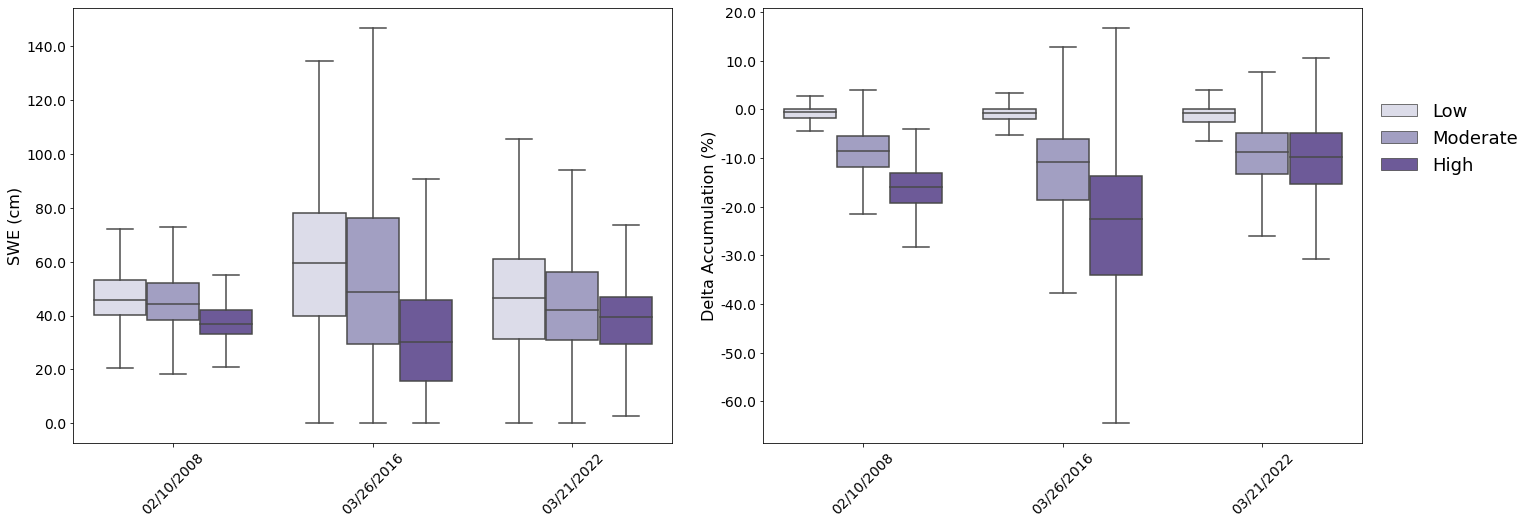

In [582]:
response_fig, axes = plt.subplots(1,2,figsize=(20, 8), sharey=False) # create a figure axis
plt.tight_layout(pad = 6, h_pad = 10)

sns.boxplot(ax=axes[0], data=response_df, x='Date', y="SWE", hue = 'response', hue_order= ["Low", "Moderate","High"], showfliers = False, palette = 'Purples') #, hue = 'nness_bins'
axes[0].set_title('', fontsize = 14); axes[0].set_xlabel(''); axes[0].set_ylabel('SWE (cm)', size = 16)
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45, fontsize = 14)
axes[0].set_yticklabels(axes[0].get_yticks(), size = 14)
axes[0].legend([], frameon=False)#bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'Response Clasas', fontsize=11,frameon=False)

sns.boxplot(ax=axes[1], data=response_df, x='Date', y="delta_acc", hue = 'response',hue_order= ["Low", "Moderate","High"], showfliers = False,palette = 'Purples') #, hue = 'nness_bins'
axes[1].set_title('', fontsize = 14); axes[1].set_xlabel('', fontsize = 14); axes[1].set_ylabel('Delta Accumulation (%)', fontsize = 16)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 45, fontsize = 14)
axes[1].set_yticklabels(axes[1].get_yticks(), size = 14)
axes[1].legend(bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, fontsize=18,frameon=False)

#axes[1].text(-0.40, 1.11,"b", ha="left", va="top", size=12, color='black', weight='normal')

response_fig.savefig('SCB/stats/figures/response_map/treatement_response.png',transparent=True,bbox_inches='tight',dpi=300)